## TD N°2 explicabilité du dataset Boston Housing

1) Charger le dataset bostong_housing
   1) Disponible dans le folder 04_interpretable_ml/td/data/
   
2) Nettoyer votre jeu de données pour créer une régression linéaire et un random forest
   1) Tester d'ajouter des features log, quadratique, ...

3)Créer un modèle baseline linéaire et random forest

4) Interpréter le modèle linéaire

5) Tuner votre random forest

6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

6) Réaliser une explicabilité par individu
   1) En utilisant la méthode ICE (PDP individuelle)
   2) LIME (Model local pour expliquer une prédiction)
   3) SHAP watterfall plot (Contribution marginale de chaque variable dans la prédiction)

7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

## Contexte du Dataset

Le Boston Housing Dataset est un ensemble de données couramment utilisé en apprentissage automatique et en statistique pour étudier les relations entre diverses caractéristiques socio-économiques et immobilières dans la ville de Boston.  
Il contient des informations sur des propriétés résidentielles et leur environnement, et est souvent utilisé pour prédire la valeur des maisons, un problème classique de régression.

**Variable dispo**: 
- CRIM : taux de criminalité par habitant par ville
- ZN : proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés
- INDUS : proportion de terrains commerciaux non commerciaux par ville
- CHAS : variable binaire indiquant la proximité de la rivière Charles (= 1 si la zone délimitée par la ville touche la rivière ; 0 sinon)
- NOX : concentration des oxydes d'azote (en parties par 10 millions)
- RM : nombre moyen de pièces par logement
- AGE : proportion des unités occupées par leur propriétaire et construites avant 1940
- DIS : distances pondérées vers cinq centres d'emploi de Boston
- RAD : indice d'accessibilité aux autoroutes radiales
- TAX : taux d'imposition foncière par valeur totale pour chaque tranche de 10 000 dollars
- PTRATIO : ratio élèves-enseignants par ville
- LSTAT : pourcentage de la population de statut socio-économique inférieur
- MEDV : valeur médiane des maisons occupées par leur propriétaire (en milliers de dollars) - **variable cible**

In [30]:
import requests
import io
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn import datasets

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#Classifier
from sklearn.linear_model import LinearRegression

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
#Regressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV
from sklearn_evaluation import plot
from sklearn.preprocessing import StandardScaler
from alibi.explainers import ALE, plot_ale
from sklearn.inspection import permutation_importance


### 1) Charger le dataset bostong_housing

In [31]:
#Télécharge directement depuis Github
url = "https://raw.githubusercontent.com/Roulitoo/cours_iae/master/04_INTERPRETABLE_ML/td/data/boston_housing.csv" 
download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=';')

In [32]:
df

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,9.67,22.4
502,502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,9.08,20.6
503,503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,5.64,23.9
504,504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,6.48,22.0


### 2)Nettoyer votre jeu de données pour créer une régression linéaire et un random forest

Penser à :

- Vérifier comment encoder vos variables qualitatives pour la modélisation 
- Analyser les distributions
- Analyser les outliers 
- Analyser les corrélations

>Tester d'ajouter des features log, quadratique, ...

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   CRIM        506 non-null    float64
 2   ZN          506 non-null    float64
 3   INDUS       506 non-null    float64
 4   CHAS        506 non-null    int64  
 5   NOX         506 non-null    float64
 6   RM          506 non-null    float64
 7   AGE         506 non-null    float64
 8   DIS         506 non-null    float64
 9   RAD         506 non-null    int64  
 10  TAX         506 non-null    float64
 11  PTRATIO     506 non-null    float64
 12  LSTAT       506 non-null    float64
 13  MEDV        506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Le typage des données est déjà correct.

In [34]:
#Nb de NA par feature
df.isna().sum()

Unnamed: 0    0
CRIM          0
ZN            0
INDUS         0
CHAS          0
NOX           0
RM            0
AGE           0
DIS           0
RAD           0
TAX           0
PTRATIO       0
LSTAT         0
MEDV          0
dtype: int64

Il n'y a pas de valeures manquantes.

In [35]:
df.describe()

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,252.500000,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,146.213884,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,126.250000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,252.500000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,378.750000,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,505.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


In [36]:
# Suppression de la colonne d'index
df = df.drop(columns=['Unnamed: 0'])

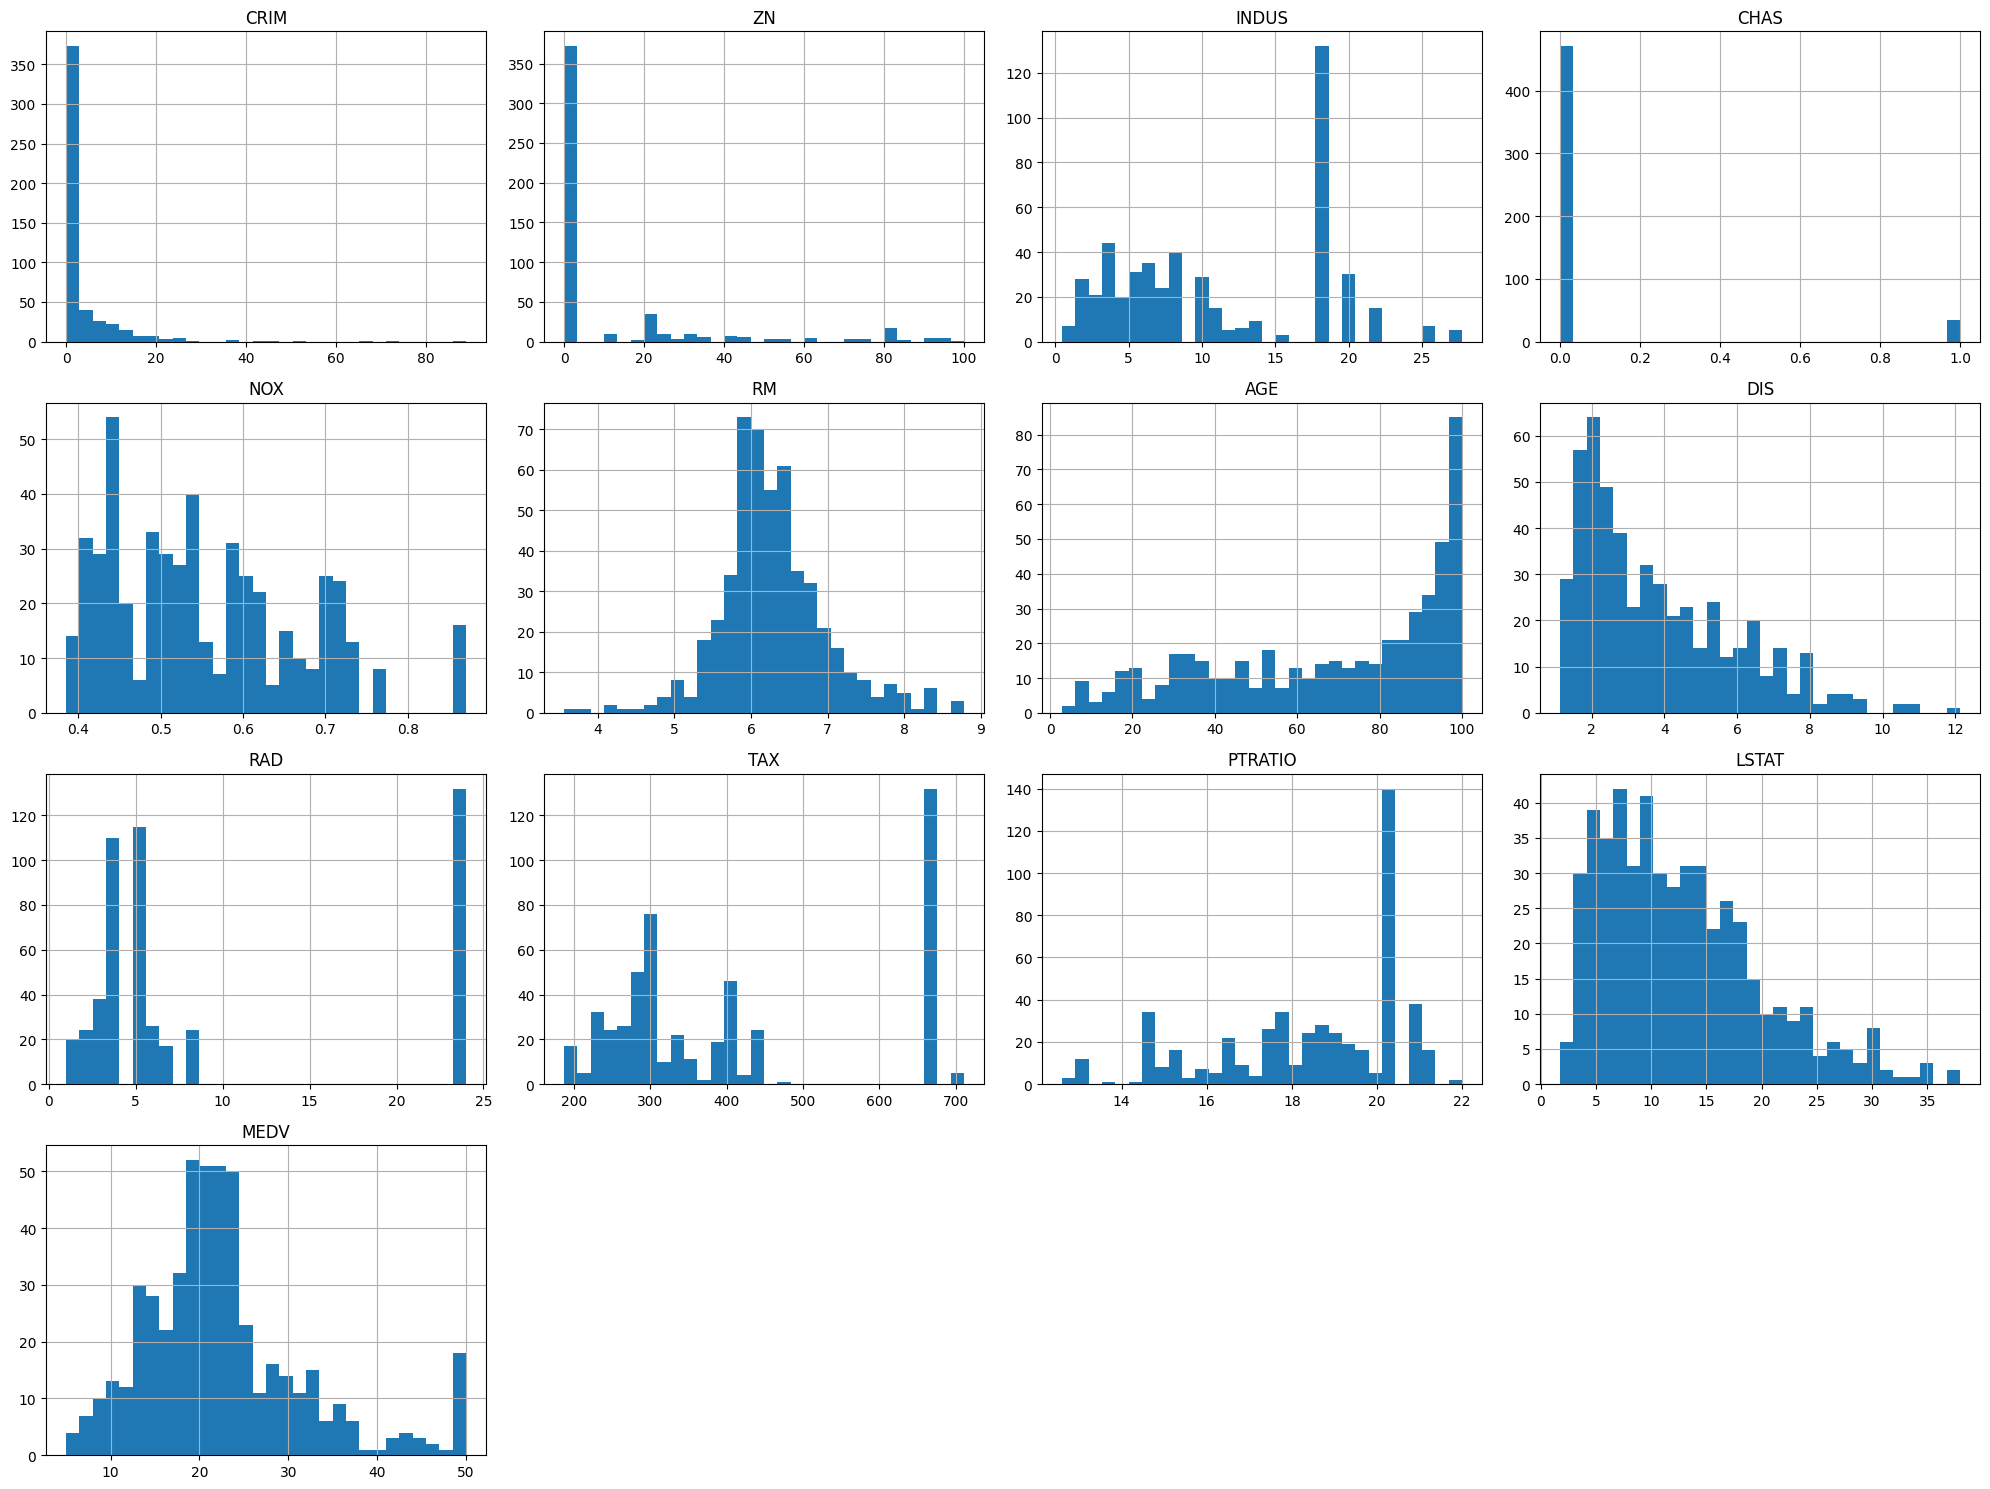

In [37]:
# Tracer les histogrammes pour chaque colonne du dataframe
df.hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

Les distributions permettent d'observer des échelles de valeures très différentes entre les variables. Nous standardisons donc nos variables explicatives afin de mieux visualiser les valeures atypiques. Certaines s'approchent d'une distributions normale comme RM ou MEDV mais d'autres laissent penser qu'elles comprennent de nombreuses valeures atypiques.

In [38]:
# Séparation en X et y
X = df.drop(columns='MEDV')

# Standardisation des colonnes explicatives (excluant la target)
sc = StandardScaler()
X_scaled = sc.fit_transform(df.drop(columns='MEDV'))

# Convertir en DataFrame pour conserver les noms des colonnes
X_scaled = pd.DataFrame(X_scaled, columns=df.drop(columns='MEDV').columns)

y = df['MEDV']

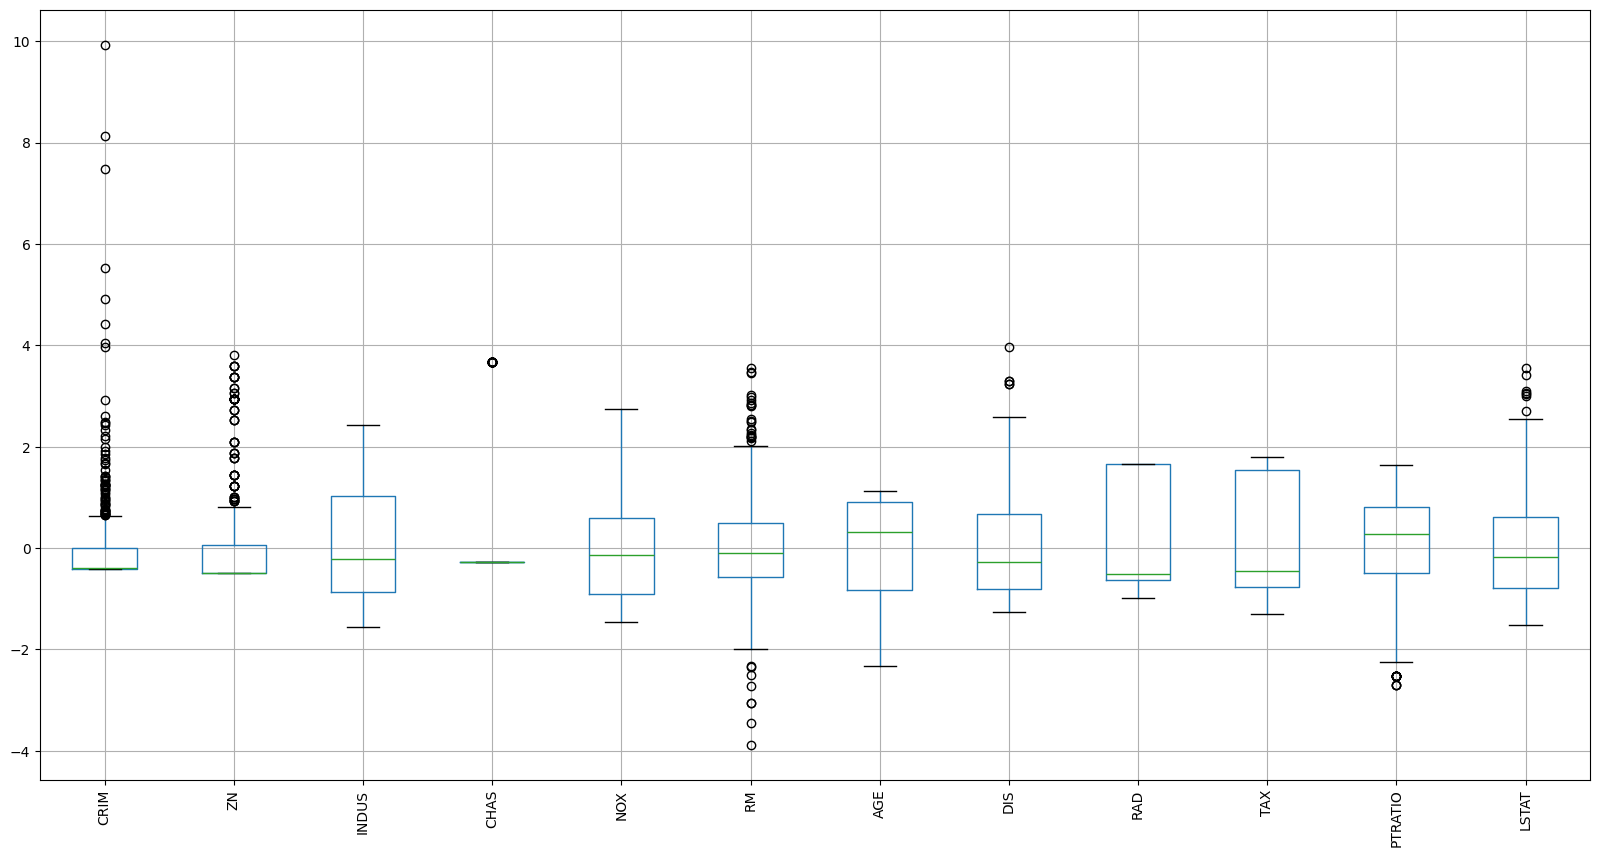

In [39]:
# Valeures atypiques
X_scaled.boxplot(figsize=(20, 10),)
plt.xticks(rotation=90)
plt.show()

Les valeures atypiques ne paraissent pas abérantes, elles apportent toutes de l'information intéressante.

In [40]:
# Matrice de corrélation
corr = X_scaled.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
CRIM,1.000000,-0.571660,0.735524,0.041537,0.821465,-0.309116,0.704140,-0.744986,0.727807,0.729045,0.465283,0.634760
ZN,-0.571660,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,-0.490074
INDUS,0.735524,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,0.638747
CHAS,0.041537,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.050575
NOX,0.821465,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,0.636828
RM,-0.309116,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,-0.640832
AGE,0.704140,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,0.657071
DIS,-0.744986,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,-0.564262
RAD,0.727807,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,0.394322
TAX,0.729045,-0.371394,0.664361,-0.044486,0.649527,-0.271898,0.526366,-0.574336,0.704876,1.000000,0.453345,0.534423


Certaines variables sont très corrélés entre elles, la régression linéaire ne gère pas bien les fortes corrélations entre var explicatives, nous allons donc créer un df avec les X utilisés pour la LR.

In [41]:
# Seuil de corrélation
threshold = 0.8

# Sélectionner les colonnes à conserver
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Garder uniquement les colonnes avec des corrélations inférieures à 80%
X_filtered = X.drop(columns=to_drop)

# Afficher les colonnes conservées
print(X_filtered.columns)

print(X_filtered.shape[1])

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'],
      dtype='object')
11


Nous avons ici nos variables explicatives standardisées et corrélés inférieure à 0.8, ce qui est parfait pour le LR !

### 3)Créer 2 modèles baseline, linéaire et random forest

In [42]:
# Séparation en train et test
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_filtered, y, test_size=0.2, random_state=0)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=0)

Ici, il est important de re standardiser après la séparation afin d'éviter la fuite de données.

In [43]:
sc.fit(X_train_lr)

X_train_lr_scaled = sc.transform(X_train_lr)
X_test_lr_scaled = sc.transform(X_test_lr)

sc.fit(X_train_rf)

X_train_rf_scaled = sc.transform(X_train_rf)
X_test_rf_scaled = sc.transform(X_test_rf)

In [44]:
from sklearn.metrics import mean_squared_error
lr = LinearRegression()

lr1 = lr.fit(X_train_lr_scaled, y_train_lr)

lr1.coef_

coeff_lr1 = pd.DataFrame(lr.coef_, index=X_filtered.columns, columns=['Coefficient'])
coeff_lr1

,Coefficient
CRIM,-0.929796
ZN,1.134330
INDUS,-0.467061
CHAS,0.665390
RM,2.580560
AGE,-0.444720
DIS,-2.423137
RAD,1.430577
TAX,-2.074490
PTRATIO,-1.849811


On suspecte une relation quadratique entre la target et DIS, si on est trop près d'une zone d'activité cela peut dévaluer la maison mais i on est trop loins aussi, on ajoute alors la forme quadratique de RAD.

In [45]:
# Ajouter la variable RAD au carré
X_filtered_sc2 = X_train_lr_scaled.copy()

X_filtered_sc2 = pd.DataFrame(X_filtered_sc2, columns=X_filtered.columns)

X_filtered_sc2['DIS_squared'] = X_filtered_sc2['DIS'] ** 2

X_filtered_sc2.head()

,CRIM,ZN,INDUS,CHAS,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,DIS_squared
0,-0.372574,-0.499608,-0.704925,3.664502,0.935678,0.693669,-0.437218,-0.162242,-0.561656,-0.484638,-0.411000,0.191159
1,-0.397099,-0.499608,-0.044878,-0.272888,-0.491181,-1.835528,0.730055,-0.624648,-0.573376,0.336491,-0.387681,0.532980
2,-0.402693,0.771168,-0.886760,-0.272888,0.857849,-0.524621,1.234769,-0.393445,-0.602677,-0.849584,-0.181919,1.524655
3,-0.405769,0.029882,-0.465819,-0.272888,-0.417676,-0.086464,0.861527,-0.509046,-0.538216,-1.488240,-0.037886,0.742229
4,2.774932,-0.499608,0.998884,-0.272888,-1.438097,0.715042,-1.021528,1.687378,1.542121,0.792674,1.911362,1.043519


X_filtered_sc2 est donc un jeu d'entrainement avec DIS au carré en plus.

In [46]:
lr2 = lr.fit(X_filtered_sc2, y_train_lr)

lr2.coef_

coeff_lr2 = pd.DataFrame(lr2.coef_, index=X_filtered_sc2.columns, columns=['Coefficient'])
coeff_lr2

,Coefficient
CRIM,-1.028690
ZN,0.918427
INDUS,-0.659744
CHAS,0.683900
RM,2.619906
AGE,-0.723395
DIS,-3.209643
RAD,1.480926
TAX,-2.225794
PTRATIO,-1.820162


Effectivement, une relation quadratique est captée

In [47]:
cv_lr = cross_val_score(lr, X_train_lr, y_train_lr, cv=5, scoring='neg_root_mean_squared_error')
print(f'Moyenne des scores : {cv_lr.mean():.3f}')
print(f'Écart-type des scores : {cv_lr.std():.3f}')

Moyenne des scores : -4.718
Écart-type des scores : 0.549


In [48]:
cv_lr2 = cross_val_score(lr2, X_filtered_sc2, y_train_lr, cv=5, scoring='neg_root_mean_squared_error')
print(f'Moyenne des scores : {cv_lr2.mean():.3f}')
print(f'Écart-type des scores : {cv_lr2.std():.3f}')

Moyenne des scores : -4.725
Écart-type des scores : 0.541


Les erreures avec DIS au carré sont plus élevées, on ne conservera pas cette variable explicative.

In [49]:
rf = RandomForestRegressor()

rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor()

In [50]:
cv_rf = cross_val_score(lr, X_train_rf, y_train_rf, cv=5, scoring='neg_root_mean_squared_error')
print(f'Moyenne des scores : {cv_rf.mean():.3f}')
print(f'Écart-type des scores : {cv_rf.std():.3f}')

Moyenne des scores : -4.607
Écart-type des scores : 0.527


### 4) Interpréter le modèle linéaire
Utiliser les méthodes intrinsèques du modèle pour l'interprétation

Étant donné que nos données sont standrdisées, la valeure absolue des variables permet de savoir l'importance de des variables. Et le signe donne le sens de la relation avec la valeur médiane des maisons occupées par leur propriétaire. Ainsi les variables les plus importantes selon la LR sont le pourcentage de la population de statut socio-économique inférieur qui joue négativement sur la target, le nombre moyen de pièces par logement qui joue positivement ainsi que la distances pondérées vers cinq centres d'emploi de Boston qui joue négatuvement.

### 5) Tuner votre random forest

In [51]:
# Définir les hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialiser GridSearchCV avec le modèle et les hyperparamètres
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)

# Exécuter GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search.fit(X_train_rf, y_train_rf)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Entraîner le modèle avec les meilleurs hyperparamètres
best_rf = grid_search.best_estimator_

# Évaluer le modèle sur les données de test
y_pred_rf_test = best_rf.predict(X_test_rf)
y_pred_rf_train = best_rf.predict(X_train_rf)

rmse_rf_test = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf_test))
rmse_rf_train = np.sqrt(mean_squared_error(y_train_rf, y_pred_rf_train))

print(f'Moyenne des scores sur les données test : {rmse_rf_test:.3f}')
print(f'Moyenne des scores sur les données train : {rmse_rf_train:.3f}')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

### 6) Interpréter globalement votre meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

In [52]:
features_names = X_train_rf.columns
features_names

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'],
      dtype='object')

#### ALE :

#### Permutation Feature importance :

/Users/karinegestin/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/karinegestin/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/karinegestin/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/karinegestin/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/karinegestin/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: Use

array([[<Axes: xlabel='CRIM', ylabel='ALE'>,
        <Axes: xlabel='ZN', ylabel='ALE'>,
        <Axes: xlabel='INDUS', ylabel='ALE'>],
       [<Axes: xlabel='CHAS', ylabel='ALE'>,
        <Axes: xlabel='NOX', ylabel='ALE'>,
        <Axes: xlabel='RM', ylabel='ALE'>],
       [<Axes: xlabel='AGE', ylabel='ALE'>,
        <Axes: xlabel='DIS', ylabel='ALE'>,
        <Axes: xlabel='RAD', ylabel='ALE'>],
       [<Axes: xlabel='TAX', ylabel='ALE'>,
        <Axes: xlabel='PTRATIO', ylabel='ALE'>,
        <Axes: xlabel='LSTAT', ylabel='ALE'>]], dtype=object)

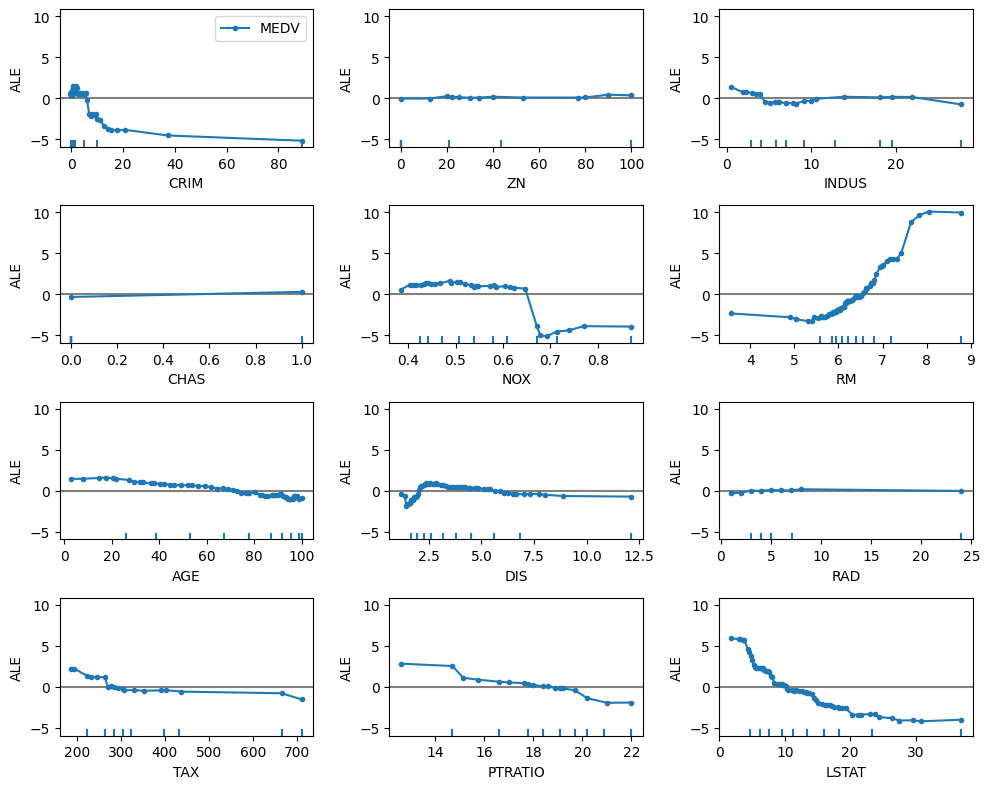

In [53]:
best_rf_ale = ALE(best_rf.predict,

             feature_names=features_names, # Liste des features où il faut calculer l'ALE

             target_names=["MEDV"] # Nom de la target

) 

#Calcul des ALE, attention il faut un format numpy arrray
rf_exp = best_rf_ale.explain(X_train_rf.to_numpy()) 


#Plot pour l'interprétation


_, ax1 = plt.subplots(figsize = (10,8))

plot_ale(rf_exp, #Résultats des ALE

     features= ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'],# Feature à représenter

     ax = ax1, 

     targets=[0] # Si classification mutliple, passer le nom de toutes les modalités à prédire

)


In [54]:
random_permutation = permutation_importance(best_rf, X_train_rf, y_train_rf,

                                    n_repeats=30,

                                    random_state=0)


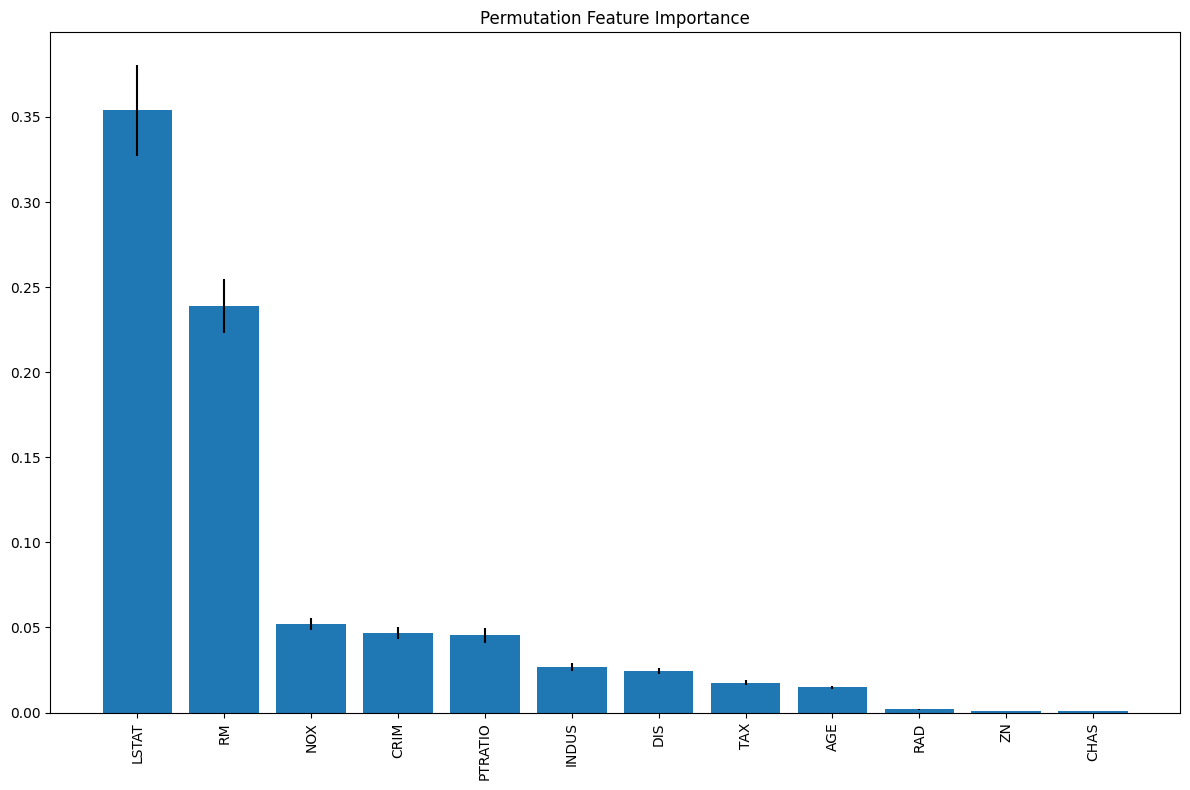

In [55]:
# Importances des caractéristiques
importances = random_permutation.importances_mean
std = random_permutation.importances_std
indices = np.argsort(importances)[::-1]

# Affichage des importances des caractéristiques
plt.figure(figsize=(12, 8))
plt.title("Permutation Feature Importance")
plt.bar(range(X_train_rf.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_train_rf.shape[1]), X_train_rf.columns[indices], rotation=90)
plt.xlim([-1, X_train_rf.shape[1]])
plt.tight_layout()
plt.show()

L'interprétation des variables et de leur importance est sensiblement la meme avec la régression linéaire que avec ALE et la permutation. On retrouve toujours LSTAT et RM comme étant des variables très importantes et ayant des effets respectivement négartifs et positifs sur la variable cible. Il y a tout de même certaines différences entre les deux, par exemple, la variable TAX apparait comme ayant peu d'effets avec les randoms forest tandis qu'elle semble plus importantes avec la régression.

### 7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

#### ICE :

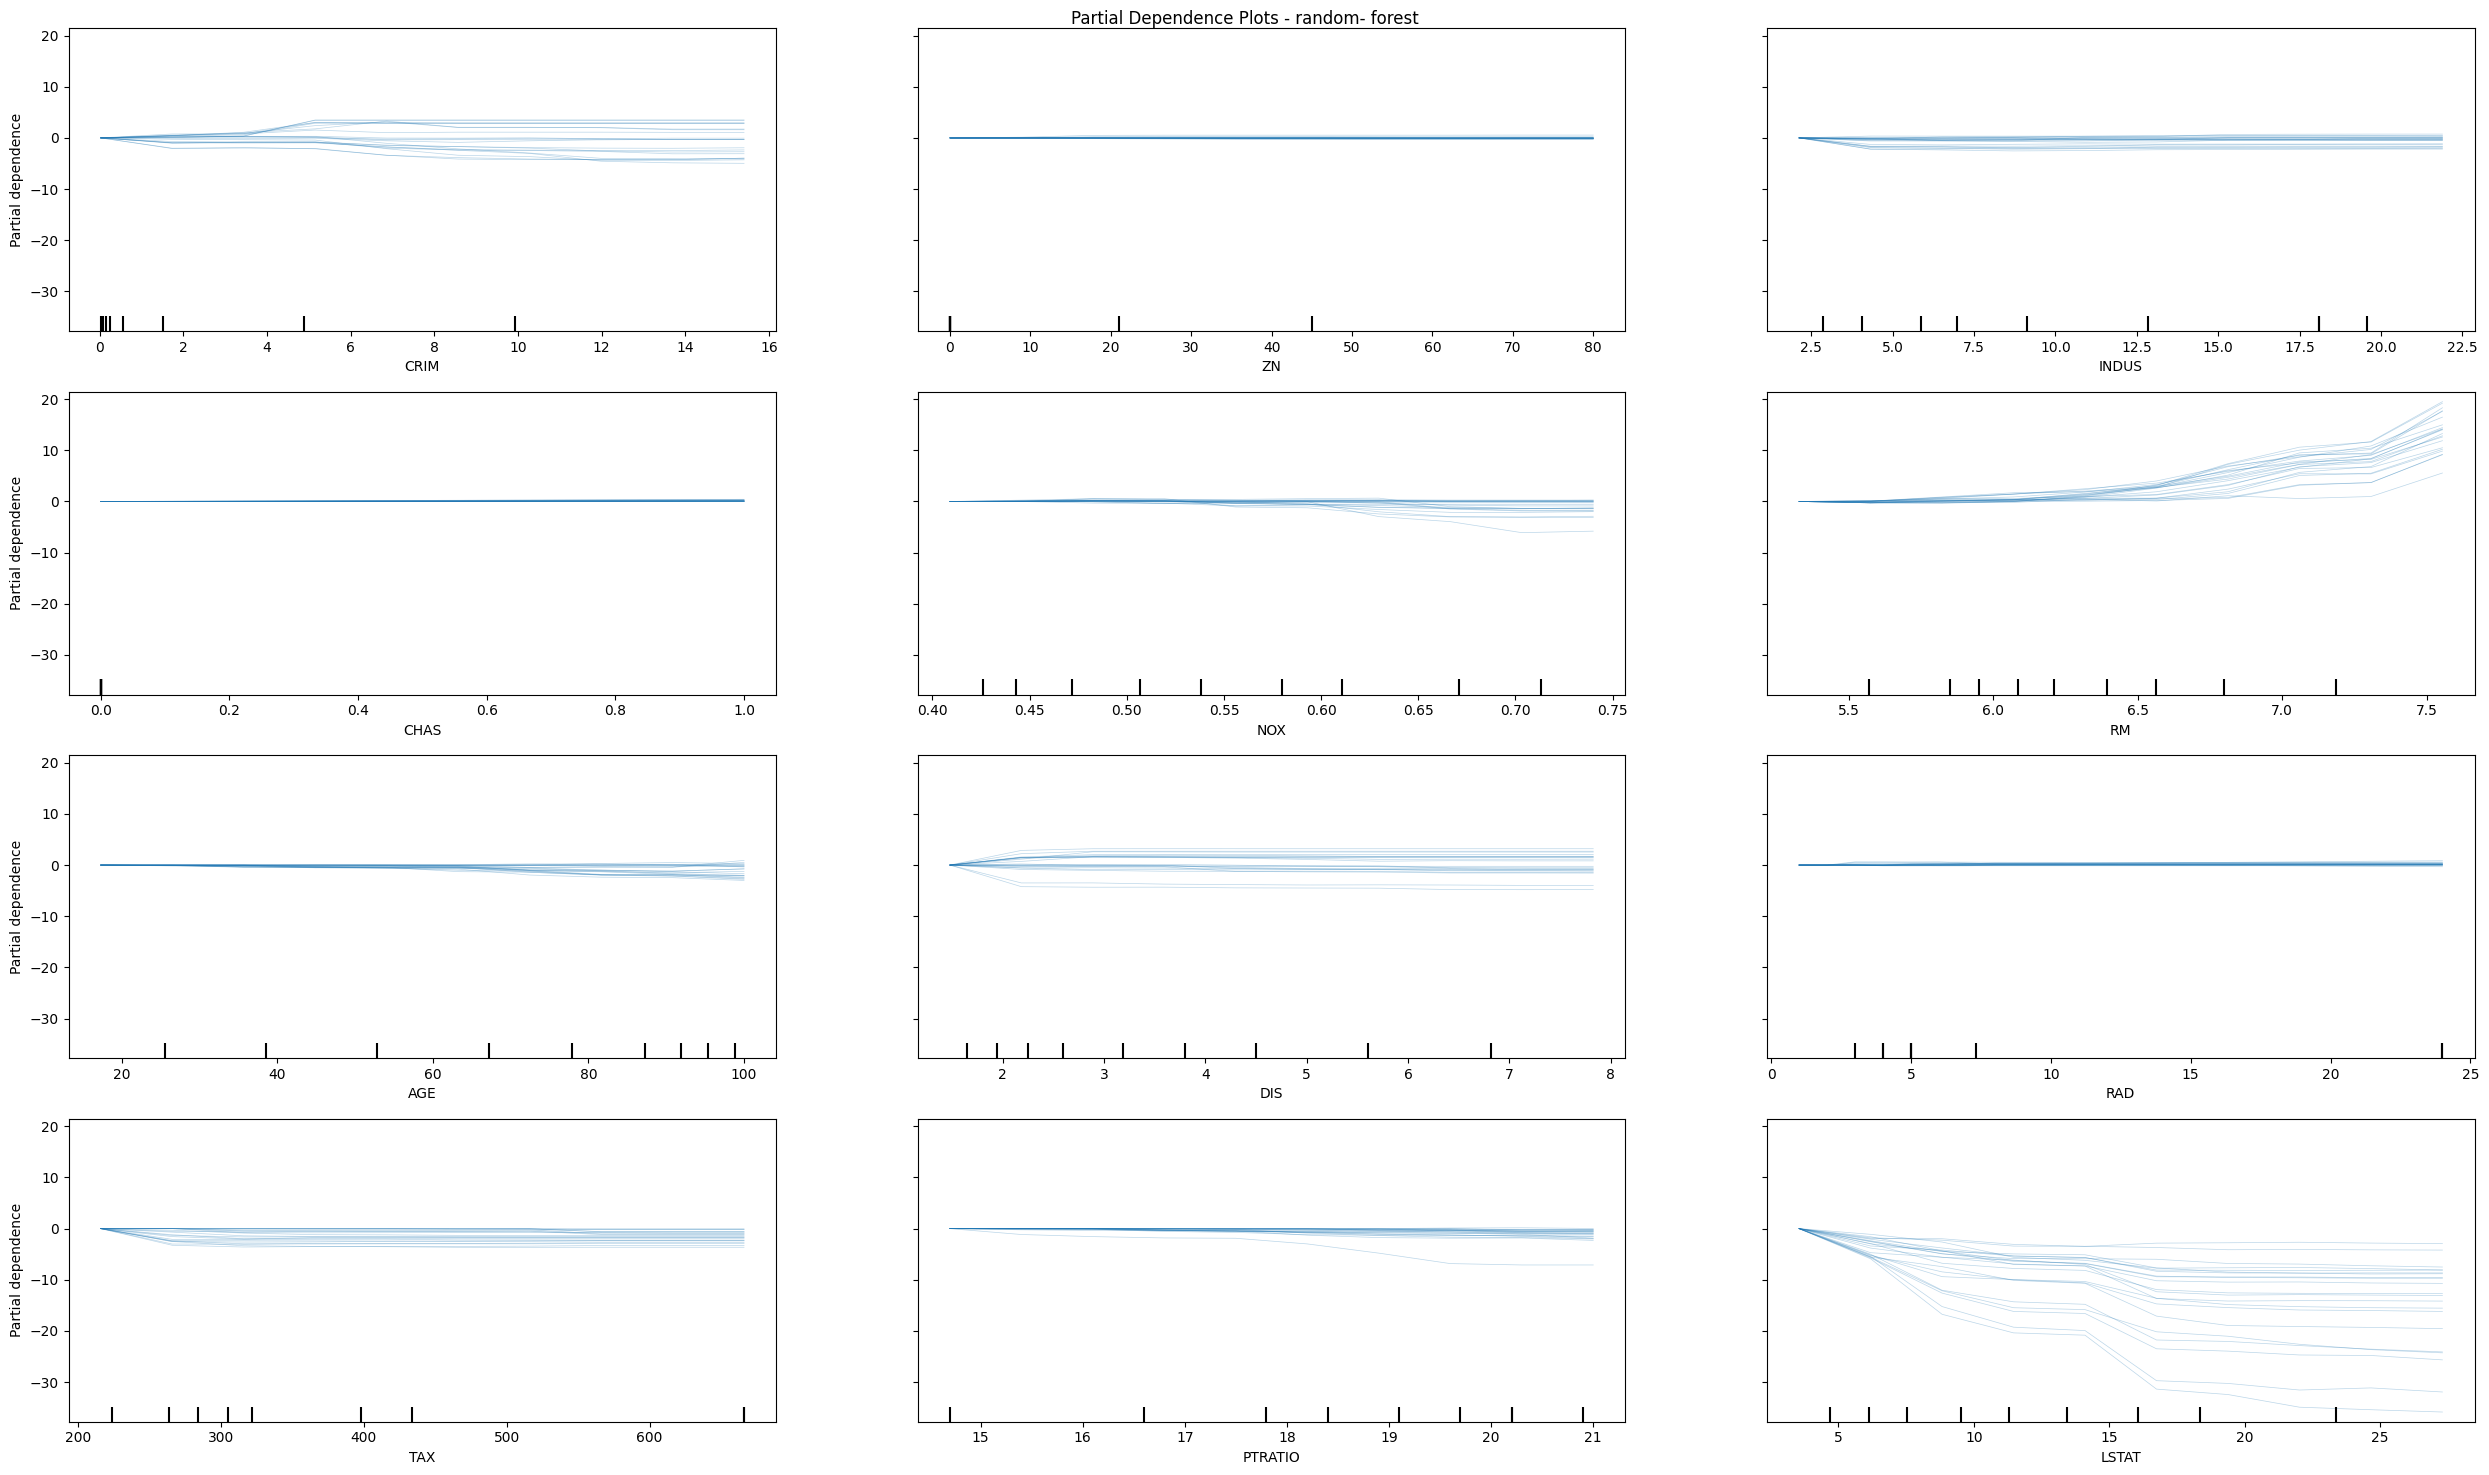

In [56]:
from sklearn.inspection import PartialDependenceDisplay
_, ax1 = plt.subplots(figsize = (25,15))
PartialDependenceDisplay.from_estimator(rf,  #votre modèle
                                         X_train_rf, 
                                         features_names,
                                         kind="individual", # On modifie ICI
                                         ax = ax1,
                                         grid_resolution=10, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=3,
                                         subsample=0.05, # 5% du jeu de données
                                         centered=True
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

le PDP semble en effet une bonne représentation des variables importantes du modèle car nous n'observons pas une hétérogénéité trop importante. Nous notons tout de même des différences significatives entre les individus pour la variable LSTAT mais le sens de la relation reste malgré tout le même.

#### LIME :

In [57]:
import lime
import lime.lime_tabular

#Création de l'explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_rf.to_numpy(),  # Attention au format numpy array obligatoire
                                                   feature_names=features_names, #Nom des features du modèle
                                                   class_names=['MEDV'] , #Variable à predire
                                                   verbose=True,
                                                   mode='regression' # Classification ou régression
                                                     )
# Index de l'individu à prédire
i = 20
# Résultat de l'explainer
exp = explainer.explain_instance(X_train_rf.loc[i], best_rf.predict, num_features=5)

/Users/karinegestin/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 25.176873084766257
Prediction_local [18.47177271]
Right: 13.599999999999936


In [58]:
#Afficher lime explainer in notebook
exp.show_in_notebook(show_table=True)

### 8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

#### beeswarm (Contribution des variables) :

In [64]:
# Importer la librairie Shap
import shap 
from shap import TreeExplainer

# Définir le module explainer de Shap, attention ce n'est pas le même si c'est un modèle basé sur des abres

explainer = shap.TreeExplainer(best_rf)

# On calcule les shap values, attention c'est très couteux en temps de calcul.
# On prend donc un échantillon

shap_values = explainer(X_train_rf.iloc[1:100])

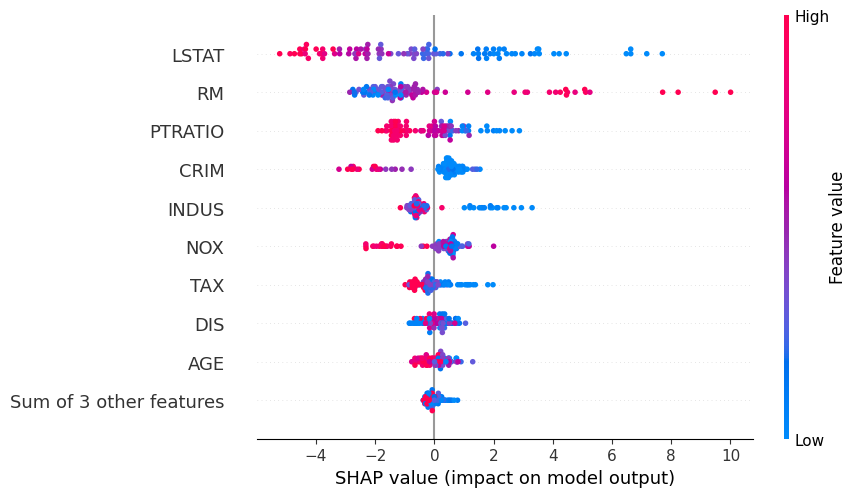

In [65]:
#Graphique beeswarm, interprétabilité globale 
shap.plots.beeswarm(shap_values)

LSTAT et RM restent les variables les plus importantes mais on voit apparaitre PTRATIO comme importante, ce que suggérait déjà LIME.

#### SCATTER :

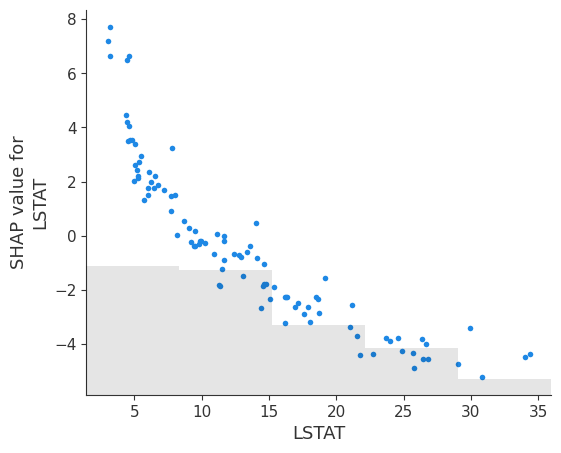

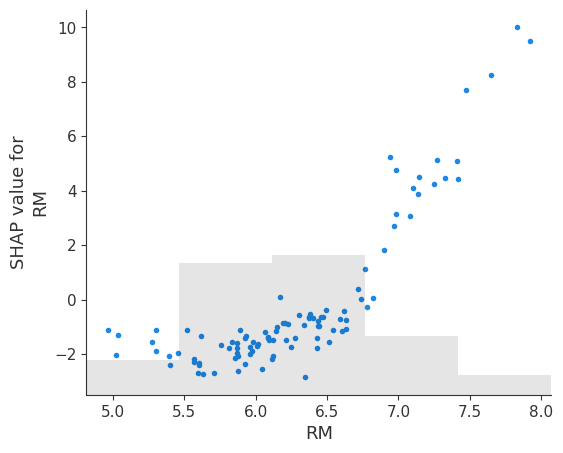

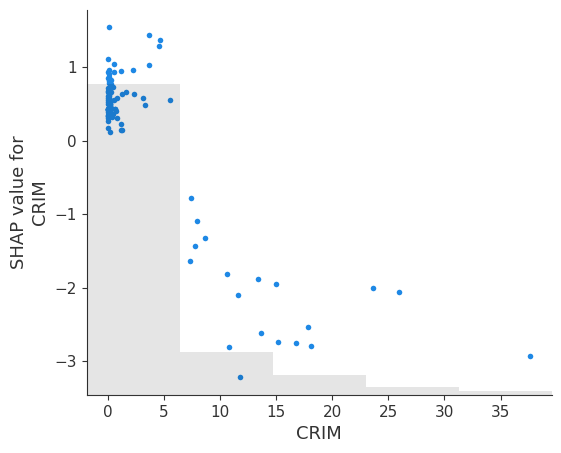

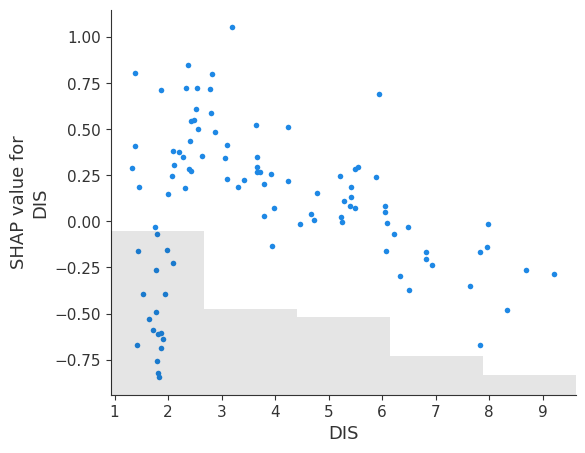

In [74]:
shap.plots.scatter(shap_values[:, 'LSTAT'])
shap.plots.scatter(shap_values[:, 'RM'])
shap.plots.scatter(shap_values[:, 'CRIM'])
shap.plots.scatter(shap_values[:, 'DIS'])